# Data Preparation and EDA

This notebook performs data merging, cleaning, and exploratory data analysis.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style (use a style that works with your matplotlib version)
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    try:
        plt.style.use('seaborn-darkgrid')
    except OSError:
        plt.style.use('default')
sns.set_palette("husl")

# Import data preparation script
import sys
sys.path.append('..')
from src.data_prep import load_and_merge_data, drop_leakage_columns, create_target_variables


## 1. Load and Merge Data


In [6]:
# Load and merge datasets
df = load_and_merge_data(data_dir='../data', random_state=42)
print(f"Shape: {df.shape}")



  Loading and Merging Data

Loading delivery_performance.csv...
  Shape: (150, 8)
Loading orders.csv...
  Shape: (200, 9)
Loading routes_distance.csv...
  Shape: (150, 7)

Merging datasets on Order_ID...
Merged dataset shape: (150, 22)
Number of unique orders: 150
Shape: (150, 22)


## 2. Remove Data Leakage


In [8]:
# Drop leakage columns
df_cleaned = drop_leakage_columns(df)
print(f"Shape after cleaning: {df_cleaned.shape}")



  Removing Data Leakage Columns

Columns to drop: ['Route', 'Origin', 'Destination', 'Customer_Segment', 'Order_Date', 'Special_Handling', 'Delivery_Status', 'Quality_Issue']

Dropped 8 columns
Shape after dropping: (150, 14)
Shape after cleaning: (150, 14)


## 3. Create Target Variables


In [10]:
# Create targets
df_final = create_target_variables(df_cleaned)

# Save
df_final.to_csv('../processed/merged.csv', index=False)



  Creating Target Variables

Delay statistics:
  Mean delay: 1.08 days
  Median delay: 0.00 days
  Max delay: 5.00 days
  Min delay: 0.00 days

Class balance (is_delayed):
is_delayed
0    80
1    70
Name: count, dtype: int64
  Delay rate: 46.67%


## 4. Exploratory Data Analysis


In [11]:
# Missing values
print("Missing Values:")
print(df_final.isnull().sum()[df_final.isnull().sum() > 0])


Missing Values:
Weather_Impact    106
dtype: int64


In [12]:
# Class balance
print("\nClass Balance (is_delayed):")
print(df_final['is_delayed'].value_counts())
print(f"\nDelay Rate: {df_final['is_delayed'].mean()*100:.2f}%")



Class Balance (is_delayed):
is_delayed
0    80
1    70
Name: count, dtype: int64

Delay Rate: 46.67%


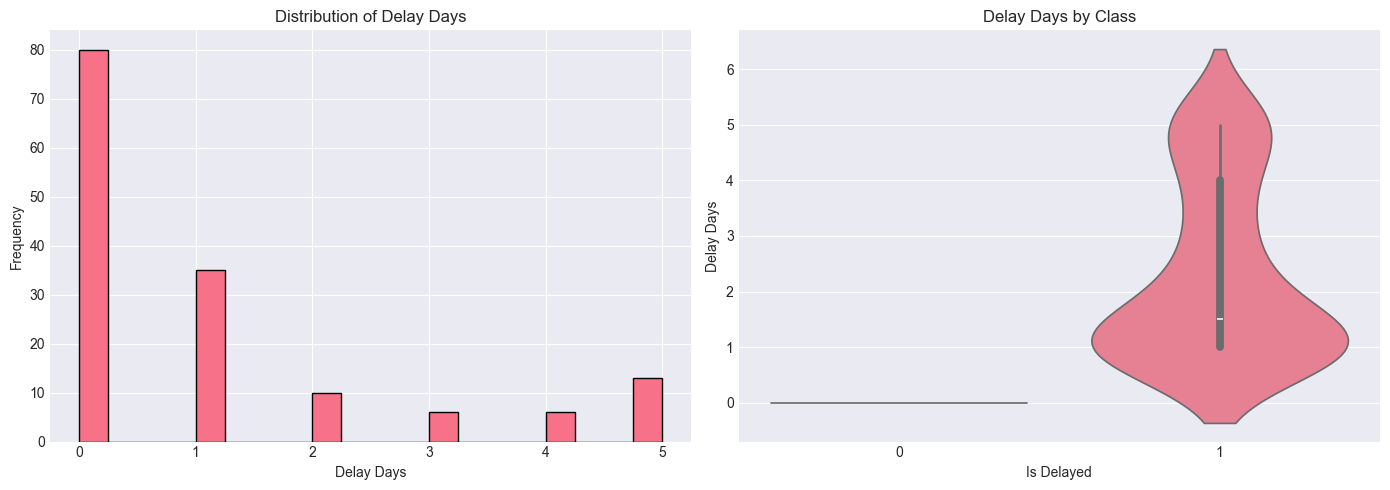

In [13]:
# Delay distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df_final['delay_days'], bins=20, edgecolor='black')
axes[0].set_xlabel('Delay Days')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Delay Days')

# Violin plot
sns.violinplot(data=df_final, y='delay_days', x='is_delayed', ax=axes[1])
axes[1].set_xlabel('Is Delayed')
axes[1].set_ylabel('Delay Days')
axes[1].set_title('Delay Days by Class')

plt.tight_layout()
plt.savefig('../models/delay_distribution.png')
plt.show()


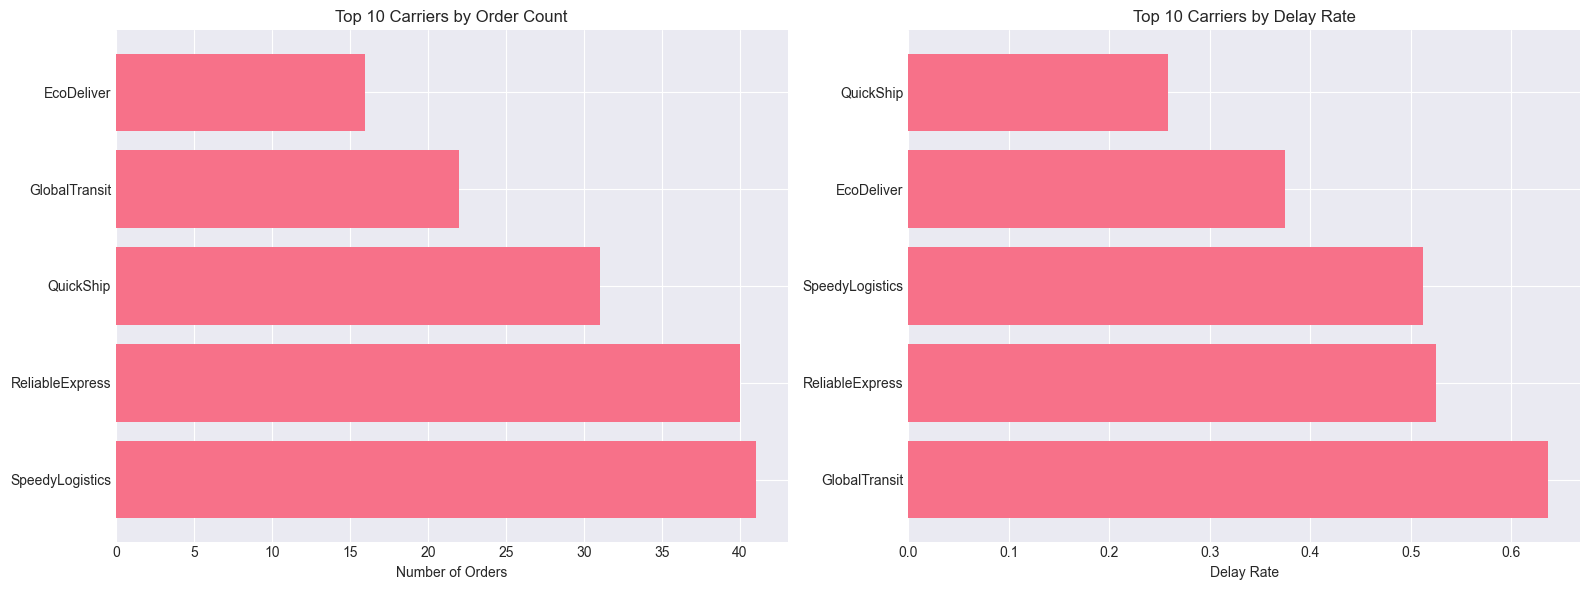

In [14]:
# Top 10 carriers by count and delay rate
carrier_stats = df_final.groupby('Carrier').agg({
    'Order_ID': 'count',
    'is_delayed': 'mean'
}).reset_index()
carrier_stats.columns = ['Carrier', 'Count', 'Delay_Rate']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# By count
top10_count = carrier_stats.nlargest(10, 'Count')
axes[0].barh(top10_count['Carrier'], top10_count['Count'])
axes[0].set_xlabel('Number of Orders')
axes[0].set_title('Top 10 Carriers by Order Count')

# By delay rate
top10_delay = carrier_stats.nlargest(10, 'Delay_Rate')
axes[1].barh(top10_delay['Carrier'], top10_delay['Delay_Rate'])
axes[1].set_xlabel('Delay Rate')
axes[1].set_title('Top 10 Carriers by Delay Rate')

plt.tight_layout()
plt.savefig('../models/carrier_analysis.png')
plt.show()


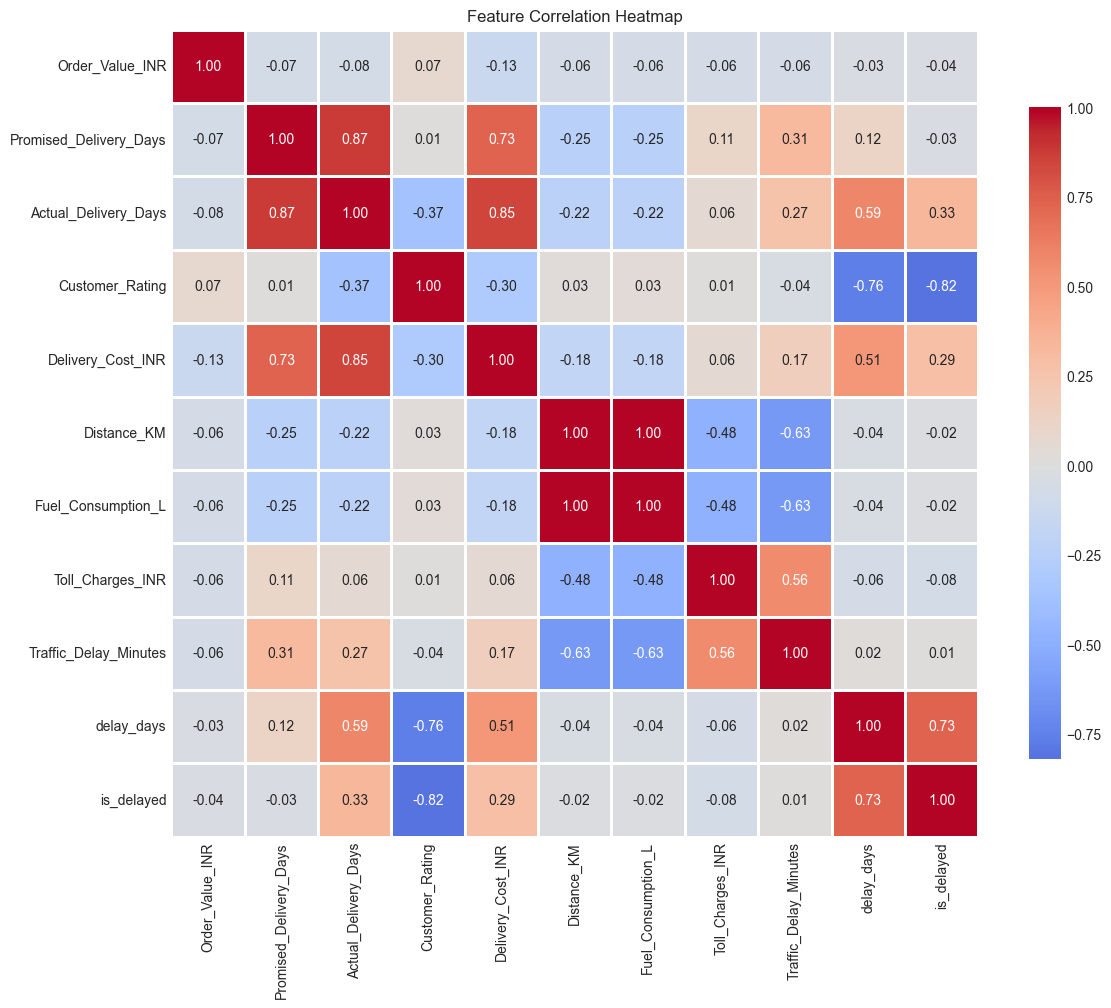

In [15]:
# Correlation heatmap
numeric_cols = df_final.select_dtypes(include=[np.number]).columns
corr = df_final[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.savefig('../models/correlation_heatmap.png')
plt.show()


In [22]:
df_final.head(5)

,Order_ID,Priority,Product_Category,Order_Value_INR,Carrier,Promised_Delivery_Days,Actual_Delivery_Days,Customer_Rating,Delivery_Cost_INR,Distance_KM,Fuel_Consumption_L,Toll_Charges_INR,Traffic_Delay_Minutes,Weather_Impact,delay_days,is_delayed
0,ORD000001,Express,Industrial,238.73,SpeedyLogistics,1,2,3,387.86,152.59,23.02,122.08,21,NaN,1,1
1,ORD000002,Express,Industrial,17.01,SpeedyLogistics,2,3,1,430.19,362.05,43.98,289.64,33,NaN,1,1
2,ORD000003,Economy,Industrial,3024.95,SpeedyLogistics,10,15,3,1039.19,519.74,65.75,415.79,2,NaN,5,1
3,ORD000004,Economy,Fashion,56.74,QuickShip,5,5,5,599.01,540.87,61.85,432.70,112,NaN,0,0
4,ORD000005,Standard,Fashion,19148.65,SpeedyLogistics,4,5,3,537.90,1251.56,147.54,1001.25,10,NaN,1,1


## 5. Key Findings

**Main Findings:**
1. Class imbalance: Approximately 46% of deliveries are delayed
2. Delay patterns: Most delays are 1-2 days, with some severe delays (5+ days)
3. Carrier variation: Significant differences in delay rates across carriers
4. Feature correlations: Distance, cost, and promised delivery days show strong relationships
5. Missing data: Weather_Impact has high missing rate (used as 'Unknown' category)
